In [1]:
import os
import math
import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim
from tensorflow.contrib.slim.python.slim import queues

/home/intern/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as mpcm

In [3]:
import sys
sys.path.append('../')

In [4]:
from datasets import dataset_factory
from nets import nets_factory
from preprocessing import preprocessing_factory

In [5]:
isess = tf.InteractiveSession()

## Some drawing routines

In [6]:
def colors_subselect(colors, num_classes=21):
    dt = len(colors) // num_classes
    sub_colors = []
    for i in range(num_classes):
        color = colors[i*dt]
        if isinstance(color[0], float):
            sub_colors.append([int(c * 255) for c in color])
        else:
            sub_colors.append([c for c in color])
    return sub_colors

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """Draw a collection of lines on an image.
    """
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def draw_rectangle(img, p1, p2, color=[255, 0, 0], thickness=2):
    cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
    
    
def draw_bbox(img, bbox, shape, label, color=[255, 0, 0], thickness=2):
    p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
    p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
    cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
    p1 = (p1[0]+15, p1[1])
    cv2.putText(img, str(label), p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 0.5, color, 1)


def bboxes_draw_on_img(img, classes, scores, bboxes, colors, thickness=2):
    shape = img.shape
    for i in range(bboxes.shape[0]):
        bbox = bboxes[i]
        color = colors[classes[i]]
        # Draw bounding box...
        p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
        p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
        cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
        # Draw text...
        s = '%s/%.3f' % (classes[i], scores[i])
        p1 = (p1[0]-5, p1[1])
        cv2.putText(img, s, p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 0.4, color, 1)


In [7]:
colors = colors_subselect(mpcm.plasma.colors, num_classes=21)
colors_tableau = [(255, 255, 255), (31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

## KITTI dataset

Check the KITTI pipeline and associated TFRecords files.

In [8]:
from datasets import kitti

DATASET_DIR = '/home/intern/data/KITTI/training/'
SPLIT_NAME = 'validation'
BATCH_SIZE = 4

# Dataset provider loading data from the dataset.
dataset = kitti.get_split(SPLIT_NAME, DATASET_DIR)
provider = slim.dataset_data_provider.DatasetDataProvider(dataset, 
                                                          shuffle=False,
                                                          common_queue_capacity=2 * BATCH_SIZE,
                                                          common_queue_min=BATCH_SIZE)
[image, shape, bboxes, labels] = provider.get(['image', 'shape', 'object/bbox', 'object/label'])
print('Dataset:', dataset.data_sources, '|', dataset.num_samples)

Dataset: /home/intern/data/KITTI/training/kitti_validation.tfrecord | 749


In [9]:
# images = tf.train.batch(
#                 [image_crop],
#                 batch_size=BATCH_SIZE,
#                 num_threads=1,
#                 capacity=5 * BATCH_SIZE)

In [10]:
# Problem: image shape is not fully defined => random crop with deterministic size.
xy = tf.random_uniform((2, ), minval=0, maxval=shape[0] // 3, dtype=tf.int64)
image_crop = tf.slice(image, [0, 0, 0], [250, 250, 3])

print('Original vs crop:', image.get_shape(), image_crop.get_shape())

Original vs crop: (?, ?, 3) (250, 250, 3)


In [11]:
# with queues.QueueRunners(sess):
# Start populating queues.
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord)

In [12]:
# Draw groundtruth bounding boxes using TF routine.
image_bboxes = tf.squeeze(tf.image.draw_bounding_boxes(tf.expand_dims(tf.to_float(image) / 255., 0), 
                                                       tf.expand_dims(bboxes, 0)))

Image shape: (375, 1242, 3) [ 375 1242    3]
Bounding boxes: [[0.47984    0.34011272 0.5868267  0.37805152]
 [0.45509332 0.28716585 0.56714666 0.3325926 ]
 [0.52312    0.13876006 0.7168533  0.24160226]
 [0.54504    0.05359098 0.71904    0.16772142]
 [0.49794668 0.3347665  0.56616    0.34241545]
 [0.51426667 0.14339775 0.5766133  0.20642512]
 [0.45216    0.7122383  0.51312    0.74567634]
 [0.42506668 0.75246376 0.5001867  0.80030596]
 [0.42784    0.823752   0.48349333 0.83636874]
 [0.43061334 0.84557164 0.48072    0.8900564 ]
 [0.4084     0.907649   0.47517332 0.97813207]
 [0.5056     0.21988727 0.56682664 0.26940417]
 [0.48616    0.37588567 0.55850667 0.40527377]]
Labels: [1 2 1 1 5 1 1 9 9 9 9 9 9]


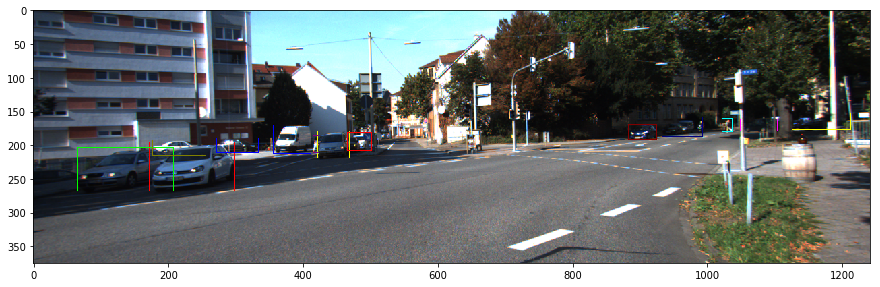

In [13]:
# Eval and display the image + bboxes.
rimg, rshape, rbboxes, rlabels = isess.run([image_bboxes, shape, bboxes, labels])

print('Image shape:', rimg.shape, rshape)
print('Bounding boxes:', rbboxes)
print('Labels:', rlabels)

fig = plt.figure(figsize = (15,15))
plt.imshow(rimg)

## Test SSD-300 model using TFRecords pipeline

Restore model and test it on some random images coming from Pascal TFRecords.

In [31]:
from nets import ssd_vgg_300
from nets import ssd_common

import tf_extended as tfe
from nets import nets_factory

from preprocessing import ssd_vgg_preprocessing
ckpt_filename = '../trained_models/ssd_384x1280_kitti_20180220/model.ckpt-67320'

In [32]:
# Image pre-processimg
out_shape = (384, 1280) 
image_pre, labels_pre, bboxes_pre, bbox_img = \
    ssd_vgg_preprocessing.preprocess_for_eval(image, labels, bboxes, out_shape, 
                                          resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# SSD construction.
reuse = True if 'ssd' in locals() else None
params = ssd_vgg_300.SSDNet.default_params
ssd = ssd_vgg_300.SSDNet(params)
with slim.arg_scope(ssd.arg_scope(weight_decay=0.0005)):
    predictions, localisations, logits, end_points = ssd.net(image_4d, is_training=False, reuse=reuse)
    
# SSD default anchor boxes.
img_shape = out_shape
layers_anchors = ssd.anchors(img_shape, dtype=np.float32)

In [33]:
# Targets encoding.
target_labels, target_localizations, target_scores = \
    ssd_common.tf_ssd_bboxes_encode(labels, bboxes_pre, layers_anchors, 
                                    num_classes=params.num_classes, no_annotation_label=params.no_annotation_label)

In [34]:

nms_threshold = 0.5

# Output decoding.

ssd_class = nets_factory.get_network('ssd_vgg_384x1280')
ssd_params = ssd_class.default_params._replace(num_classes=9)
ssd_net = ssd_class(ssd_params)


localisations = ssd_net.bboxes_decode(localisations, layers_anchors)

tclasses, tscores, tbboxes = ssd_common.tf_ssd_bboxes_select_all_classes(predictions, localisations, select_threshold=0.8) #, select_threshold=0.8
tclasses, tscores, tbboxes = tfe.bboxes_sort_all_classes(tclasses, tscores, tbboxes, top_k=400)#, priority_inside=False
tclasses, tscores, tbboxes = tfe.bboxes_nms_batch_all_classes(tclasses, tscores, tbboxes, nms_threshold=0.5)

#tclasses, tscores, tbboxes = ssd_common.tf_ssd_bboxes_select(predictions, localisations)
#tclasses, tscores, tbboxes = ssd_common.tf_bboxes_sort(tclasses, tscores, tbboxes, top_k=400)
#tclasses, tscores, tbboxes = ssd_common.tf_bboxes_nms_batch(tclasses, tscores, tbboxes,
#                                                            nms_threshold=0.3, num_classes=ssd.params.num_classes)


# Initialize variables.
init_op = tf.global_variables_initializer()
isess.run(init_op)
# Restore SSD model.
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

INFO:tensorflow:Restoring parameters from ../trained_models/ssd_384x1280_kitti_20180220/model.ckpt-67320


In [35]:
# Run model.
#[rimg, rpredictions, rlocalisations, glabels, gbboxes, rbbox_img, rt_labels, rt_localizations, rt_scores] = \
    #isess.run([image_4d, predictions, localisations, labels, bboxes_pre, bbox_img, 
               #target_labels, target_localizations, target_scores])

    
    # Run model.
[rimg, rpredictions, rlocalisations, rclasses, rscores, rbboxes, glabels, gbboxes, rbbox_img, rt_labels, rt_localizations, rt_scores] = \
    isess.run([image_4d, predictions, localisations, tclasses, tscores, tbboxes,
               labels, bboxes_pre, bbox_img, 
               target_labels, target_localizations, target_scores])

In [36]:
def bboxes_select(classes, scores, bboxes, threshold=0.1):
    """Sort bounding boxes by decreasing order and keep only the top_k
    """
    mask = scores > threshold
    classes = classes[mask]
    scores = scores[mask]
    bboxes = bboxes[mask]
    return classes, scores, bboxes

print(rclasses, rscores)
print(rscores.shape)

rclasses, rscores, rbboxes = bboxes_select(rclasses, rscores, rbboxes, 0.1)
# print(list(zip(rclasses, rscores)))
# print(rbboxes)


# Compute classes and bboxes from the net outputs.
#rclasses, rscores, rbboxes,_,_ = ssd_common.ssd_bboxes_select(rpredictions, rlocalisations, layers_anchors,
#                                                               threshold=0.5, img_shape=img_shape, 
#                                                               num_classes=9, decode=True)
#rbboxes = ssd_common.bboxes_clip(rbbox_img, rbboxes)
#rclasses, rscores, rbboxes = ssd_common.bboxes_sort(rclasses, rscores, rbboxes, top_k=400, priority_inside=False)
#rclasses, rscores, rbboxes = ssd_common.bboxes_nms(rclasses, rscores, rbboxes, threshold=0.35)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]] [[0.99995065 0.99955946 0.9994823  0.97567016 0.97418845 0.9698346
  0.90681    0.8915264  0.84325016 0.8292607  0.8209294  0.81714284
  0.8133262  0.8112332  0.80899924 0.8052185  0.8044948  0.80029684
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        

Labels / scores: [(1, 0.99995065), (1, 0.99955946), (1, 0.9994823), (1, 0.97567016), (1, 0.97418845), (1, 0.9698346), (1, 0.90681), (1, 0.8915264), (1, 0.84325016), (1, 0.8292607), (1, 0.8209294), (1, 0.81714284), (1, 0.8133262), (1, 0.8112332), (1, 0.80899924), (1, 0.8052185), (1, 0.8044948), (1, 0.80029684)]
Grountruth labels: [1, 1, 1, 1, 1, 1, 9, 9]
[[0.51592    0.09219807 0.99733335 0.37569243]
 [0.49176    0.55004025 0.68530667 0.6252013 ]
 [0.47416    0.42957327 0.5674667  0.4623108 ]
 [0.48069334 0.5259501  0.58736    0.5659662 ]
 [0.47597334 0.4519082  0.53605336 0.47173914]
 [0.46730667 0.51517713 0.5344267  0.53751206]
 [0.46522668 0.477029   0.51085335 0.49288246]
 [0.46672    0.49917874 0.49738666 0.5117955 ]]
[[0.49609375 0.5488281  0.75390625 0.6261718 ]
 [0.4700952  0.43837792 0.5509434  0.47115475]
 [0.47038954 0.5117891  0.5504438  0.53580534]
 [0.46223956 0.42738128 0.57942706 0.46253753]
 [0.48201352 0.52589464 0.5804865  0.564432  ]
 [0.47882384 0.451778   0.542009

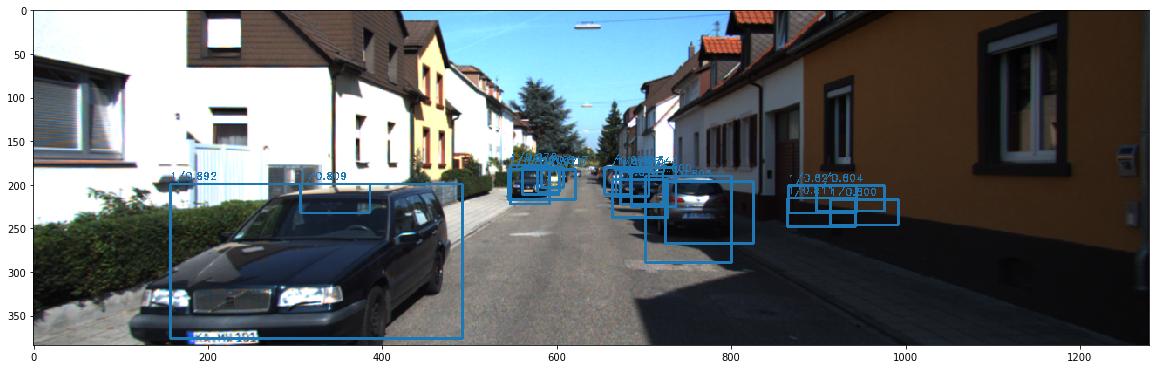

In [37]:
# Draw bboxes
img_bboxes = np.copy(ssd_vgg_preprocessing.np_image_unwhitened(rimg[0]))
bboxes_draw_on_img(img_bboxes, rclasses, rscores, rbboxes, colors_tableau, thickness=2)
# bboxes_draw_on_img(img_bboxes, test_labels, test_scores, test_bboxes, colors_tableau, thickness=1)

print('Labels / scores:', list(zip(rclasses, rscores)))
print('Grountruth labels:', list(glabels))
print(gbboxes)
print(rbboxes)

fig = plt.figure(figsize = (20,20))
plt.imshow(img_bboxes)

In [38]:
test_bboxes = []
test_labels = []
test_scores = []
for i in range(0, 3):
    yref, xref, href, wref = layers_anchors[i]
    ymin = yref - href / 2.
    xmin = xref - wref / 2.
    ymax = yref + href / 2.
    xmax = xref + wref / 2.
    bb = np.stack([ymin, xmin, ymax, xmax], axis=-1)
    
    idx = yref.shape[0] // 2
    idx = np.random.randint(yref.shape[0])
#     print(bb[idx, idx].shape)
    test_bboxes.append(bb[idx, idx])
    test_labels.append(np.ones(href.shape, dtype=np.int64) * i)
    test_scores.append(np.ones(href.shape))

test_bboxes = np.concatenate(test_bboxes)
test_labels = np.concatenate(test_labels)
test_scores = np.concatenate(test_scores)

print(test_bboxes.shape)
print(test_labels.shape)
print(test_scores.shape)


(16, 4)
(16,)
(16,)


In [39]:
rt_labels, rt_localizations, rt_scores
for i in range(len(rt_labels)):
    print(rt_labels[i].shape)
    idxes = np.where(rt_labels[i] > 0)
#     idxes = np.where(rt_scores[i] > 0.)
    print(idxes)
    print(rt_localizations[i][idxes])
    print(list(zip(rt_labels[i][idxes], rt_scores[i][idxes])))
    print()

(48, 160, 4)
(array([21, 21, 21, ..., 47, 47, 47]), array([67, 67, 68, ..., 60, 61, 61]), array([0, 1, 0, ..., 3, 1, 2]))
[[  14.669437     13.3296795     3.454298      2.6712835 ]
 [  10.021133      9.105905      1.5489477     0.76593316]
 [  10.859918     13.3296795     3.454298      2.6712835 ]
 ...
 [-124.2825      -30.121183     15.980517      9.142587  ]
 [ -62.636547    -29.099827     12.342299      8.970105  ]
 [ -64.83499     -60.242367     12.514782     12.608323  ]]
[(1, 0.00014059937), (1, 0.012079792), (1, 0.0018844816), (1, 0.030125212), (1, 0.013875425), (1, 0.0036344556), (1, 0.048825692), (1, 0.03448844), (1, 0.0045894054), (1, 0.06821785), (1, 0.03786038), (1, 0.0045894054), (1, 0.07124882), (1, 0.03786038), (1, 0.0045894054), (1, 0.062353622), (1, 0.03786038), (1, 0.0031113646), (1, 0.080919795), (1, 0.062641315), (1, 0.0013632125), (1, 0.07487864), (1, 0.062641315), (1, 0.047819555), (1, 0.029637018), (1, 0.022089591), (1, 0.008033197), (1, 0.038884953), (1, 0.02956

In [ ]:
# fig = plt.figure(figsize = (8,8))
# plt.imshow(ssd_preprocessing.np_image_unwhitened(rimg[0]))
# print('Ground truth labels: ', rlabels)

In [ ]:
# Request threads to stop. Just to avoid error messages
# coord.request_stop()
# coord.join(threads)

In [ ]:
PleaseStopHere;

## Test SSD-300 model using sample images

Restore model and test it on some sample images.

In [ ]:
# Input placeholder.
net_shape = (300, 300)
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_preprocessing.preprocess_for_eval(
    img_input, labels, None, net_shape, resize=ssd_preprocessing.Resize.PAD_AND_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Re-define the model
reuse = True if 'ssd' in locals() else None
with slim.arg_scope(ssd.arg_scope(weight_decay=0.0005)):
    predictions, localisations, logits, end_points = ssd.net(image_4d, is_training=False, reuse=reuse)

In [ ]:
# Main processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=0.35, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    # Compute classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes, rlayers, ridxes = ssd_common.ssd_bboxes_select(
            rpredictions, rlocalisations, layers_anchors,
            threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
#     print(list(zip(classes, scores)))
#     print(rlayers)
#     print(ridxes)
    
    rbboxes = ssd_common.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = ssd_common.bboxes_sort(rclasses, rscores, rbboxes, 
                                                        top_k=400, priority_inside=True, margin=0.0)
    rclasses, rscores, rbboxes = ssd_common.bboxes_nms(rclasses, rscores, rbboxes, threshold=nms_threshold)
    # Resize bboxes to original image shape.
    rbboxes = ssd_common.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes
    

In [ ]:
# Test on demo images.
path = '../demo/'
image_names = sorted(os.listdir(path))
img = mpimg.imread(path + image_names[3])

rclasses, rscores, rbboxes =  process_image(img)

# Draw results.
img_bboxes = np.copy(img)
bboxes_draw_on_img(img_bboxes, rclasses, rscores, rbboxes, colors_tableau, thickness=2)

fig = plt.figure(figsize = (12, 12))
plt.imshow(img_bboxes)

In [ ]:
idxes = np.where(inside)
rscores[idxes]